In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline

In [13]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [3]:
def read_csv(path):
    df = pd.read_csv(path)

    df['density'] = df['number_of_total_atoms'] / (df['lattice_vector_1_ang'] * df['lattice_vector_2_ang'] * df['lattice_vector_3_ang'] * np.sin(df['lattice_angle_alpha_degree'] * np.pi / 180) * np.sin(df['lattice_angle_beta_degree'] * np.pi / 180) * np.sin(df['lattice_angle_gamma_degree'] * np.pi / 180))

    spacegroup = pd.get_dummies(df['spacegroup'].astype('str'), drop_first=True, prefix='spacegroup')

    total_atoms = pd.get_dummies(df['number_of_total_atoms'].astype('str'), drop_first=True, prefix='number_of_total_atoms')

    df2 = pd.merge(df, spacegroup, left_index=True, right_index=True)
    df2.drop('spacegroup', axis=1, inplace=True)

    df3 = pd.merge(df2, total_atoms, left_index=True, right_index=True)
    df3.drop('number_of_total_atoms', axis=1, inplace=True)
    return df3

In [4]:
df_train = read_csv('data/train.csv')
df_train.head()

,id,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,...,spacegroup_167,spacegroup_194,spacegroup_206,spacegroup_227,spacegroup_33,number_of_total_atoms_20.0,number_of_total_atoms_30.0,number_of_total_atoms_40.0,number_of_total_atoms_60.0,number_of_total_atoms_80.0
0,1,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,...,0,0,0,0,1,0,0,0,0,1
1,2,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,...,0,1,0,0,0,0,0,0,0,1
2,3,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,...,0,0,0,1,0,0,0,1,0,0
3,4,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,...,1,0,0,0,0,0,1,0,0,0
4,5,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,...,0,1,0,0,0,0,0,0,0,1


In [17]:
X_train = df_train.drop(['id', 'formation_energy_ev_natom', 'bandgap_energy_ev'], axis=1)
y_fe_train = np.log1p(df_train['formation_energy_ev_natom'].values)
y_bg_train = np.log1p(df_train['bandgap_energy_ev'].values)

In [18]:
X_train.columns

Index(['percent_atom_al', 'percent_atom_ga', 'percent_atom_in',
       'lattice_vector_1_ang', 'lattice_vector_2_ang', 'lattice_vector_3_ang',
       'lattice_angle_alpha_degree', 'lattice_angle_beta_degree',
       'lattice_angle_gamma_degree', 'density', 'spacegroup_167',
       'spacegroup_194', 'spacegroup_206', 'spacegroup_227', 'spacegroup_33',
       'number_of_total_atoms_20.0', 'number_of_total_atoms_30.0',
       'number_of_total_atoms_40.0', 'number_of_total_atoms_60.0',
       'number_of_total_atoms_80.0'],
      dtype='object')

In [49]:
def evaluate(X_train, y_train, ax=None):
    estimator_fe = xgb.XGBRegressor(random_state=0)
    score_fe = np.sqrt(-cross_val_score(estimator_fe, X_train, y=y_train,
               scoring='neg_mean_squared_error',
               cv=5,
              ))
    print(np.mean(score_fe), np.std(score_fe))
    estimator_fe.fit(X_train, y_fe_train)
    xgb.plot_importance(estimator_fe, ax=ax)

0.0333640444944 0.00144914458687


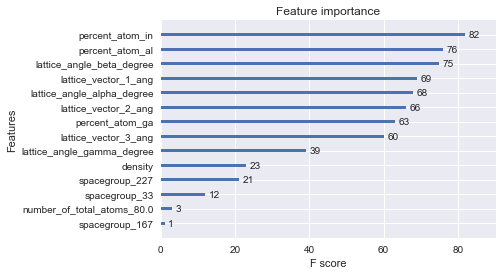

In [36]:
evaluate(X_train, y_fe_train)

0.088295062632 0.00216902257646


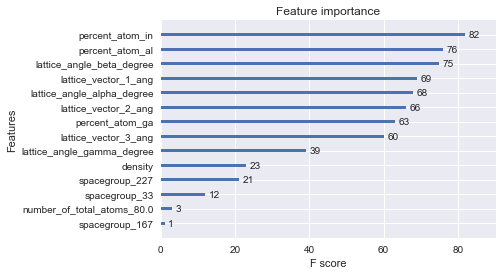

In [37]:
evaluate(X_train, y_bg_train)

In [38]:
def read_csv_no_onehot(path):
    df = pd.read_csv(path)
    df['density'] = df['number_of_total_atoms'] / (df['lattice_vector_1_ang'] * df['lattice_vector_2_ang'] * df['lattice_vector_3_ang'] * np.sin(df['lattice_angle_alpha_degree'] * np.pi / 180) * np.sin(df['lattice_angle_beta_degree'] * np.pi / 180) * np.sin(df['lattice_angle_gamma_degree'] * np.pi / 180))
    return df

0.0334157046297 0.00167728681635
0.0882821489849 0.00191353190776


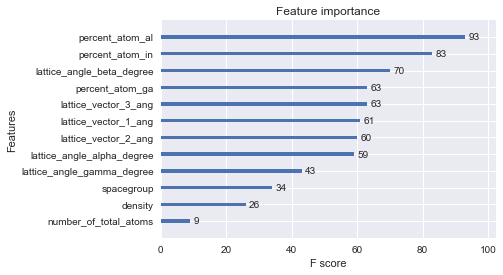

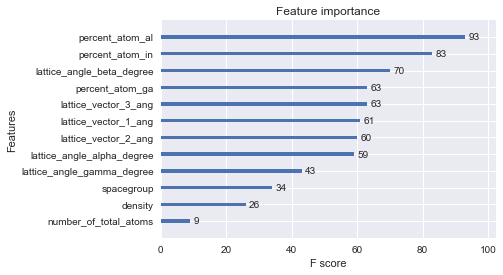

In [39]:
df_train_no_onehot = read_csv_no_onehot('data/train.csv')
X_train_no_onehot = df_train_no_onehot.drop(['id', 'formation_energy_ev_natom', 'bandgap_energy_ev',], axis=1)
evaluate(X_train_no_onehot, y_fe_train)
evaluate(X_train_no_onehot, y_bg_train)

0.0333004217848 0.00162148039116
0.0880493170812 0.00183731443248


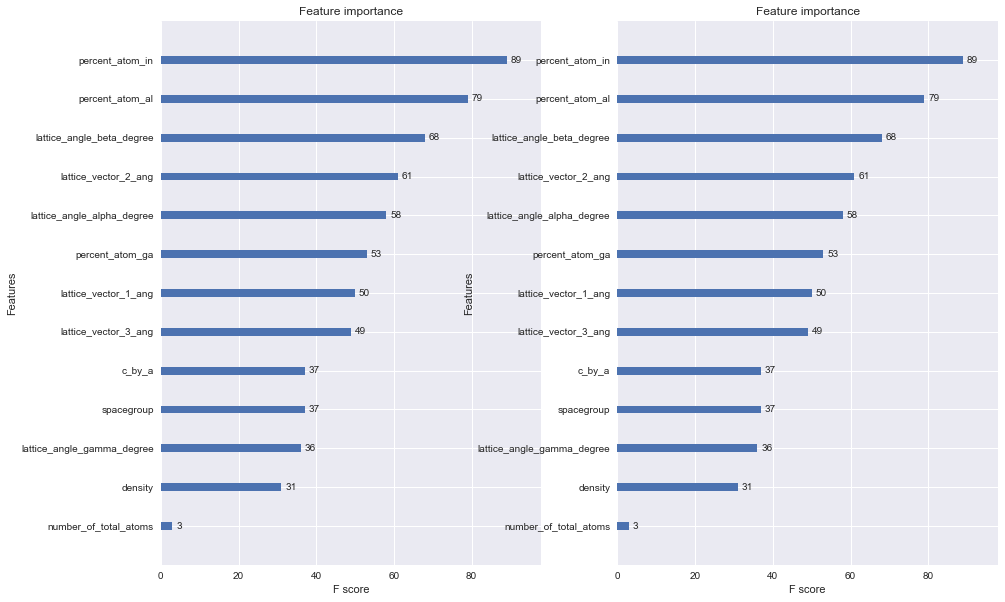

In [69]:
def c_by_a():
    df_train = pd.read_csv('data/train.csv')
    df_train['density'] = df_train['number_of_total_atoms'] / (df_train['lattice_vector_1_ang'] * df_train['lattice_vector_2_ang'] * df_train['lattice_vector_3_ang'] * np.sin(df_train['lattice_angle_alpha_degree'] * np.pi / 180) * np.sin(df_train['lattice_angle_beta_degree'] * np.pi / 180) * np.sin(df_train['lattice_angle_gamma_degree'] * np.pi / 180))
    df_train['c_by_a'] = df_train['lattice_vector_3_ang'] / df_train['lattice_vector_1_ang']
    X_train_no_onehot = df_train.drop(['id', 'formation_energy_ev_natom', 'bandgap_energy_ev',], axis=1)
    # X_train_no_onehot = df_train.drop(['id', 'formation_energy_ev_natom', 'bandgap_energy_ev', 'lattice_angle_alpha_degree'], axis=1)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10))
    evaluate(X_train_no_onehot, y_fe_train, ax=ax1)
    evaluate(X_train_no_onehot, y_bg_train, ax=ax2)
    
c_by_a()

0.0335195191606 0.00158773578413
0.0876110436655 0.00187460755227


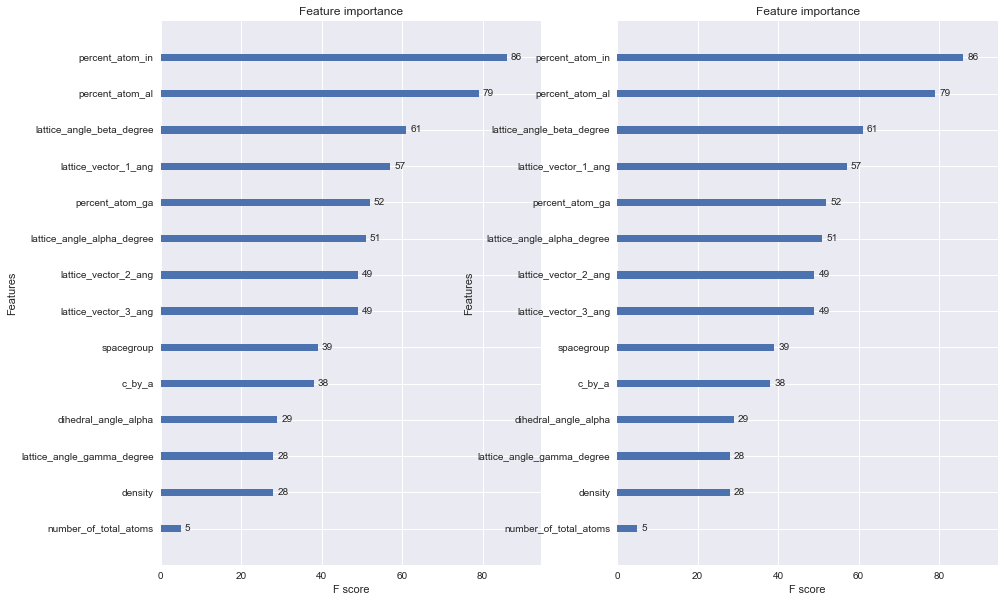

In [81]:
def test():
    df_train = pd.read_csv('data/train.csv')
    df_train['density'] = df_train['number_of_total_atoms'] / (df_train['lattice_vector_1_ang'] * df_train['lattice_vector_2_ang'] * df_train['lattice_vector_3_ang'] * np.sin(df_train['lattice_angle_alpha_degree'] * np.pi / 180) * np.sin(df_train['lattice_angle_beta_degree'] * np.pi / 180) * np.sin(df_train['lattice_angle_gamma_degree'] * np.pi / 180))
    df_train['c_by_a'] = df_train['lattice_vector_3_ang'] / df_train['lattice_vector_1_ang']
    # df_train['lattice_angle_alpha_degree'] = np.cos(np.radians(df_train['lattice_angle_alpha_degree']))
    # df_train['lattice_angle_beta_degree'] = np.cos(np.radians(df_train['lattice_angle_beta_degree']))
    # df_train['lattice_angle_gamma_degree'] = np.cos(np.radians(df_train['lattice_angle_gamma_degree']))
    alpha = np.radians(df_train['lattice_angle_alpha_degree'])
    beta = np.radians(df_train['lattice_angle_beta_degree'])
    gamma = np.radians(df_train['lattice_angle_gamma_degree'])
    df_train['dihedral_angle_alpha'] = (np.cos(beta) * np.cos(gamma) - np.cos(alpha)) / np.sin(beta) / np.cos(gamma)
    # df_train['dihedral_angle_beta'] = (np.cos(gamma) * np.cos(alpha) - np.cos(beta)) / np.sin(gamma) / np.cos(alpha)
    # df_train['dihedral_angle_gamma'] = (np.cos(alpha) * np.cos(beta) - np.cos(gamma)) / np.sin(alpha) / np.cos(beta)
    X_train_no_onehot = df_train.drop(['id', 'formation_energy_ev_natom', 'bandgap_energy_ev',], axis=1)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10))
    evaluate(X_train_no_onehot, y_fe_train, ax=ax1)
    evaluate(X_train_no_onehot, y_bg_train, ax=ax2)
    
test()